In [110]:
import jax.numpy as np
import dLux as dl
import dLuxToliman as dlT
import dLux.utils as dlu
import matplotlib.pyplot as plt
import jax

# constructing the telescope:
wf_npixels = 128 # 128 lowest power of 2 necessary
diameter = 0.125 #
period = 304e-6 
difference = np.pi * 0.348

apertureLayer = dlT.TolimanApertureLayer(wf_npixels)

layers = [
    (
        'aperture',
        apertureLayer
    )
]

import jax.random as jr
key = 0

psf_npixels = 300
assumed_pixel_scale = 0.375
true_pixel_scale = assumed_pixel_scale*jr.uniform(jr.PRNGKey(key), minval=0.9, maxval=1.1)
print(true_pixel_scale)
oversample = 4 # 4 seems good

optics = dl.AngularOpticalSystem(wf_npixels,diameter,layers,psf_npixels,true_pixel_scale,oversample)

0.36888427


In [111]:
import pandas as pd
from scipy.stats import binned_statistic

# Step 1: Load from CSV
df = pd.read_csv("alpha_cen_A_spectrum.csv")  # replace with correct path if needed

# Step 2: Apply mask (wavelengths in Ångstroms, like original)
mask = (df["wavelength"] >= 5200) & (df["wavelength"] <= 6500)

# Step 3: Extract and convert to meters
wavelengths = df["wavelength"][mask].to_numpy() * 1e-10  # meters
weights = df["flux"][mask].to_numpy()

# Step 4: Downsample using binning
n_bins = 500
bin_means, bin_edges, _ = binned_statistic(
    wavelengths, weights, statistic='mean', bins=n_bins
)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Step 5: Create the point source
flux_single_exposure = 2.909*10**7 # from max charles code
n_exposures = 4000 # (4 sidelobes, 1000 exposures = 500 seconds of exposure time)

# normalising the weights
weights_norm = bin_means/np.sum(bin_means)

# modify the weights with a normal distribution on each
std = 0.02
epsilon = 1e-6 # no weight can be below this.
weights_modified = weights_norm * np.maximum((1 + std * jr.normal(jr.PRNGKey(key),n_bins)), epsilon * np.ones(n_bins))

alpha_cen_a_source = dl.PointSource(
    wavelengths=bin_centers,
    weights=weights_modified,
    flux= n_exposures*flux_single_exposure
)

In [112]:
alpha_cen_a_scope = dl.Telescope(optics,alpha_cen_a_source)

sidelobescope = dlT.SideLobeTelescope(alpha_cen_a_scope, period, difference)

In [113]:
# going to use the model for a single sidelobe rather than all 4. 
# saves a lot of memory / makes calculation quicker
# basically no difference in information content so long as source is centered
center_wl = 585e-9

sidelobe_raw = sidelobescope.model_sidelobes(center_wavelength = center_wl, assumed_pixel_scale = assumed_pixel_scale, downsample = oversample)

Model time: 22.8606 seconds.


In [114]:
sidelobe_poisson = jr.poisson(jr.PRNGKey(key),sidelobe_raw)

In [115]:
# add pixel scale optimiser
weights_path = 'telescope.source.spectrum.weights'
pixel_scale_path = 'telescope.optics.psf_pixel_scale'

parameters = [weights_path, pixel_scale_path]

# initial guess for weights
model = sidelobescope.set(weights_path, weights_norm)

# initial guess for pixel scale
model = model.set(pixel_scale_path, np.array(assumed_pixel_scale))

# Optimisation
import zodiax as zdx
import optax

# want to optimise pixel scale immediately, then do weights
pixel_scale_optimiser = optax.adam(1e-3)

# bascially 0 learning rate until 50th iteration.
weights_sched = optax.piecewise_constant_schedule(init_value=1e-4*1e-8,
                                                  boundaries_and_scales={50 : int(1e8)}) 

weights_optimiser = optax.adam(weights_sched)

optimisers = [weights_optimiser, pixel_scale_optimiser]

optim, opt_state = zdx.get_optimiser(model, parameters, optimisers)

In [116]:
@zdx.filter_jit
@zdx.filter_value_and_grad(parameters)
def loss_fn(model, data):
    out = model.model_sidelobes(center_wavelength = center_wl, assumed_pixel_scale = assumed_pixel_scale, downsample = oversample)
    return -np.sum(jax.scipy.stats.poisson.logpmf(data, out))

In [117]:
%%time
loss, grads = loss_fn(model, sidelobe_poisson) # Compile
print("Initial Loss: {}".format(int(loss)))

Model time: 11.1983 seconds.
Initial Loss: 478413152
CPU times: user 5min 5s, sys: 22.8 s, total: 5min 28s
Wall time: 3min 7s


In [118]:
from tqdm import tqdm

losses, models_out = [], []
with tqdm(range(100),desc='Gradient Descent') as t:
    for i in t: 
        loss, grads = loss_fn(model, sidelobe_poisson)

        updates, opt_state = optim.update(grads, opt_state)

        # # prevent negative weights
        # # Get current weights
        weights = model.get(weights_path)

        #print(weights[0])
        # # Get update for weights
        weight_updates = updates.get(weights_path)
        #print(weight_updates[0])
        # # Clamp the update: ensure weights + update >= 0
        # already have epsilon defined above
        safe_updates = np.where(weights + weight_updates < epsilon, epsilon-weights, weight_updates)

        # Create a copy of updates and replace the weights update with safe update
        updates = updates.set(weights_path, safe_updates)
        print("Pixel scale grad:", grads.get(pixel_scale_path))
        print("Pixel scale update:", updates.get(pixel_scale_path))

        model = zdx.apply_updates(model, updates)
        losses.append(loss)
        models_out.append(model)
        t.set_description("Log Loss: {:.3f}".format(np.log10(loss))) # update the progress bar

Gradient Descent:   0%|          | 0/100 [00:00<?, ?it/s]

Log Loss: 8.680:   1%|          | 1/100 [00:48<1:20:34, 48.83s/it]

Pixel scale grad: 159168970000.0
Pixel scale update: -0.0009999934
Model time: 9.1219 seconds.


Log Loss: 8.525:   2%|▏         | 2/100 [03:59<3:36:23, 132.48s/it]

Pixel scale grad: 127024900000.0
Pixel scale update: -0.0009879222


Log Loss: 8.350:   3%|▎         | 3/100 [04:53<2:36:05, 96.55s/it] 

Pixel scale grad: 97393470000.0
Pixel scale update: -0.00096462964


Log Loss: 8.149:   4%|▍         | 4/100 [05:44<2:05:43, 78.58s/it]

Pixel scale grad: 76359910000.0
Pixel scale update: -0.0009348134


Log Loss: 7.889:   5%|▌         | 5/100 [06:31<1:46:32, 67.29s/it]

Pixel scale grad: 58940800000.0
Pixel scale update: -0.00089811237


Log Loss: 7.520:   6%|▌         | 6/100 [07:17<1:33:50, 59.90s/it]

Pixel scale grad: 39460045000.0
Pixel scale update: -0.0008472332


Log Loss: 6.841:   7%|▋         | 7/100 [08:11<1:29:59, 58.06s/it]

Pixel scale grad: 23118907000.0
Pixel scale update: -0.0007836914


Log Loss: 6.491:   8%|▊         | 8/100 [09:02<1:25:39, 55.87s/it]

Pixel scale grad: -16906959000.0
Pixel scale update: -0.0006556984


Log Loss: 7.309:   9%|▉         | 9/100 [09:49<1:20:04, 52.80s/it]

Pixel scale grad: -32560343000.0
Pixel scale update: -0.0005139267


Log Loss: 7.598:  10%|█         | 10/100 [10:34<1:15:57, 50.64s/it]

Pixel scale grad: -42521960000.0
Pixel scale update: -0.0003714657


Log Loss: 7.753:  11%|█         | 11/100 [11:20<1:13:04, 49.26s/it]

Pixel scale grad: -48794018000.0
Pixel scale update: -0.00023630835


Log Loss: 7.836:  12%|█▏        | 12/100 [12:06<1:10:40, 48.19s/it]

Pixel scale grad: -52593893000.0
Pixel scale update: -0.000112559515


Log Loss: 7.873:  13%|█▎        | 13/100 [12:51<1:08:32, 47.27s/it]

Pixel scale grad: -54421490000.0
Pixel scale update: -2.2600125e-06


Log Loss: 7.873:  14%|█▍        | 14/100 [13:37<1:06:55, 46.70s/it]

Pixel scale grad: -54456890000.0
Pixel scale update: 9.363477e-05


Log Loss: 7.843:  15%|█▌        | 15/100 [14:22<1:05:23, 46.15s/it]

Pixel scale grad: -52946702000.0
Pixel scale update: 0.00017502643


Log Loss: 7.783:  16%|█▌        | 16/100 [15:07<1:04:17, 45.92s/it]

Pixel scale grad: -50056503000.0
Pixel scale update: 0.0002421877


Log Loss: 7.690:  17%|█▋        | 17/100 [15:53<1:03:35, 45.97s/it]

Pixel scale grad: -46218125000.0
Pixel scale update: 0.0002959432


Log Loss: 7.558:  18%|█▊        | 18/100 [16:39<1:02:56, 46.06s/it]

Pixel scale grad: -40952490000.0
Pixel scale update: 0.00033605975


Log Loss: 7.371:  19%|█▉        | 19/100 [17:26<1:02:28, 46.28s/it]

Pixel scale grad: -34251661000.0
Pixel scale update: 0.0003620236


Log Loss: 7.087:  20%|██        | 20/100 [18:14<1:02:31, 46.89s/it]

Pixel scale grad: -28206290000.0
Pixel scale update: 0.0003763243


Log Loss: 6.517:  21%|██        | 21/100 [19:01<1:01:39, 46.83s/it]

Pixel scale grad: -17412979000.0
Pixel scale update: 0.00037209297


Log Loss: 5.786:  22%|██▏       | 22/100 [19:49<1:01:07, 47.02s/it]

Pixel scale grad: 4098987300.0
Pixel scale update: 0.00033144606


Log Loss: 6.694:  23%|██▎       | 23/100 [20:35<1:00:08, 46.86s/it]

Pixel scale grad: 20430848000.0
Pixel scale update: 0.00026478968


Log Loss: 7.052:  24%|██▍       | 24/100 [21:22<59:28, 46.95s/it]  

Pixel scale grad: 26630267000.0
Pixel scale update: 0.00019252746


Log Loss: 7.222:  25%|██▌       | 25/100 [22:10<58:57, 47.17s/it]

Pixel scale grad: 29604997000.0
Pixel scale update: 0.000121157216


Log Loss: 7.310:  26%|██▌       | 26/100 [22:58<58:28, 47.41s/it]

Pixel scale grad: 31677247000.0
Pixel scale update: 5.2304313e-05


Log Loss: 7.344:  27%|██▋       | 27/100 [23:45<57:26, 47.21s/it]

Pixel scale grad: 32674714000.0
Pixel scale update: -1.226047e-05


Log Loss: 7.336:  28%|██▊       | 28/100 [24:31<56:27, 47.05s/it]

Pixel scale grad: 32435186000.0
Pixel scale update: -7.0684735e-05


Log Loss: 7.289:  29%|██▉       | 29/100 [25:19<55:44, 47.10s/it]

Pixel scale grad: 31122782000.0
Pixel scale update: -0.000121632715


Log Loss: 7.198:  30%|███       | 30/100 [26:06<55:06, 47.24s/it]

Pixel scale grad: 29117293000.0
Pixel scale update: -0.00016458887


Log Loss: 7.049:  31%|███       | 31/100 [26:54<54:36, 47.49s/it]

Pixel scale grad: 26578051000.0
Pixel scale update: -0.0001993462


Log Loss: 6.798:  32%|███▏      | 32/100 [27:42<53:50, 47.51s/it]

Pixel scale grad: 22343533000.0
Pixel scale update: -0.00022352635


Log Loss: 6.333:  33%|███▎      | 33/100 [28:30<53:13, 47.66s/it]

Pixel scale grad: 13700123000.0
Pixel scale update: -0.00022970604


Log Loss: 5.678:  34%|███▍      | 34/100 [29:17<52:11, 47.45s/it]

Pixel scale grad: 391948100.0
Pixel scale update: -0.00020999102


Log Loss: 6.245:  35%|███▌      | 35/100 [30:05<51:31, 47.57s/it]

Pixel scale grad: -12281164000.0
Pixel scale update: -0.00016698183


Log Loss: 6.653:  36%|███▌      | 36/100 [30:56<52:03, 48.81s/it]

Pixel scale grad: -20115480000.0
Pixel scale update: -0.00011185356


Log Loss: 6.843:  37%|███▋      | 37/100 [31:43<50:26, 48.04s/it]

Pixel scale grad: -23867038000.0
Pixel scale update: -5.380974e-05


Log Loss: 6.919:  38%|███▊      | 38/100 [32:30<49:20, 47.76s/it]

Pixel scale grad: -25288063000.0
Pixel scale update: 2.161812e-06


Log Loss: 6.916:  39%|███▉      | 39/100 [33:17<48:29, 47.70s/it]

Pixel scale grad: -25234858000.0
Pixel scale update: 5.3251908e-05


Log Loss: 6.841:  40%|████      | 40/100 [34:04<47:34, 47.58s/it]

Pixel scale grad: -23820917000.0
Pixel scale update: 9.714494e-05


Log Loss: 6.678:  41%|████      | 41/100 [34:53<47:02, 47.85s/it]

Pixel scale grad: -20614038000.0
Pixel scale update: 0.0001308361


Log Loss: 6.385:  42%|████▏     | 42/100 [35:40<46:04, 47.66s/it]

Pixel scale grad: -14867116000.0
Pixel scale update: 0.00014995765


Log Loss: 5.908:  43%|████▎     | 43/100 [36:29<45:35, 48.00s/it]

Pixel scale grad: -6423449600.0
Pixel scale update: 0.00014995493


Log Loss: 5.736:  44%|████▍     | 44/100 [37:17<44:42, 47.90s/it]

Pixel scale grad: 2935497700.0
Pixel scale update: 0.00013013833


Log Loss: 6.157:  45%|████▌     | 45/100 [38:04<43:40, 47.64s/it]

Pixel scale grad: 10617418000.0
Pixel scale update: 9.542125e-05


Log Loss: 6.429:  46%|████▌     | 46/100 [38:50<42:38, 47.38s/it]

Pixel scale grad: 15455243000.0
Pixel scale update: 5.30681e-05


Log Loss: 6.553:  47%|████▋     | 47/100 [39:38<41:51, 47.38s/it]

Pixel scale grad: 17766705000.0
Pixel scale update: 9.216957e-06


Log Loss: 6.572:  48%|████▊     | 48/100 [40:24<40:46, 47.05s/it]

Pixel scale grad: 18138673000.0
Pixel scale update: -3.174093e-05


Log Loss: 6.503:  49%|████▉     | 49/100 [41:16<41:12, 48.48s/it]

Pixel scale grad: 16820318000.0
Pixel scale update: -6.631683e-05


Log Loss: 6.335:  50%|█████     | 50/100 [42:05<40:26, 48.53s/it]

Pixel scale grad: 13739653000.0
Pixel scale update: -9.1121845e-05


Log Loss: 6.053:  51%|█████     | 51/100 [42:52<39:28, 48.34s/it]

Pixel scale grad: 8852666000.0
Pixel scale update: -0.00010287005


Log Loss: 5.695:  52%|█████▏    | 52/100 [43:44<39:29, 49.37s/it]

Pixel scale grad: 1595469000.0
Pixel scale update: -9.712209e-05


Log Loss: 5.894:  53%|█████▎    | 53/100 [44:33<38:27, 49.09s/it]

Pixel scale grad: -4891200000.0
Pixel scale update: -7.690569e-05


Log Loss: 6.191:  54%|█████▍    | 54/100 [45:20<37:18, 48.66s/it]

Pixel scale grad: -9412113000.0
Pixel scale update: -4.7859172e-05


Log Loss: 6.348:  55%|█████▌    | 55/100 [46:08<36:19, 48.43s/it]

Pixel scale grad: -11730592000.0
Pixel scale update: -1.5829351e-05


Log Loss: 6.392:  56%|█████▌    | 56/100 [46:58<35:44, 48.74s/it]

Pixel scale grad: -12133648000.0
Pixel scale update: 1.4426304e-05


Log Loss: 6.348:  57%|█████▋    | 57/100 [47:47<35:01, 48.87s/it]

Pixel scale grad: -10957097000.0
Pixel scale update: 3.9303417e-05


Log Loss: 6.235:  58%|█████▊    | 58/100 [48:36<34:10, 48.82s/it]

Pixel scale grad: -8492356000.0
Pixel scale update: 5.615523e-05


Log Loss: 6.085:  59%|█████▉    | 59/100 [49:23<33:06, 48.44s/it]

Pixel scale grad: -5097315300.0
Pixel scale update: 6.336886e-05


Log Loss: 5.976:  60%|██████    | 60/100 [50:10<32:04, 48.12s/it]

Pixel scale grad: -1288846300.0
Pixel scale update: 6.0677852e-05


Log Loss: 5.985:  61%|██████    | 61/100 [50:57<31:02, 47.77s/it]

Pixel scale grad: 2318814700.0
Pixel scale update: 4.9329286e-05


Log Loss: 6.066:  62%|██████▏   | 62/100 [51:44<30:06, 47.53s/it]

Pixel scale grad: 5195832000.0
Pixel scale update: 3.1798423e-05


Log Loss: 6.132:  63%|██████▎   | 63/100 [52:31<29:13, 47.40s/it]

Pixel scale grad: 7016708600.0
Pixel scale update: 1.1206891e-05


Log Loss: 6.143:  64%|██████▍   | 64/100 [53:19<28:23, 47.31s/it]

Pixel scale grad: 7653548500.0
Pixel scale update: -9.222573e-06


Log Loss: 6.092:  65%|██████▌   | 65/100 [54:07<27:44, 47.56s/it]

Pixel scale grad: 7112932000.0
Pixel scale update: -2.6519048e-05


Log Loss: 5.986:  66%|██████▌   | 66/100 [54:53<26:47, 47.28s/it]

Pixel scale grad: 5507650000.0
Pixel scale update: -3.8215214e-05


Log Loss: 5.858:  67%|██████▋   | 67/100 [55:40<25:48, 46.94s/it]

Pixel scale grad: 3085365200.0
Pixel scale update: -4.265319e-05


Log Loss: 5.782:  68%|██████▊   | 68/100 [56:27<25:03, 46.98s/it]

Pixel scale grad: 260900060.0
Pixel scale update: -3.9361024e-05


Log Loss: 5.808:  69%|██████▉   | 69/100 [57:14<24:19, 47.08s/it]

Pixel scale grad: -2438766800.0
Pixel scale update: -2.9273551e-05


Log Loss: 5.881:  70%|███████   | 70/100 [58:00<23:27, 46.92s/it]

Pixel scale grad: -4506124300.0
Pixel scale update: -1.4596983e-05


Log Loss: 5.926:  71%|███████   | 71/100 [58:47<22:41, 46.96s/it]

Pixel scale grad: -5584565000.0
Pixel scale update: 1.6740413e-06


Log Loss: 5.915:  72%|███████▏  | 72/100 [59:34<21:50, 46.82s/it]

Pixel scale grad: -5532397000.0
Pixel scale update: 1.6387425e-05


Log Loss: 5.853:  73%|███████▎  | 73/100 [1:00:19<20:50, 46.33s/it]

Pixel scale grad: -4417123300.0
Pixel scale update: 2.680811e-05


Log Loss: 5.769:  74%|███████▍  | 74/100 [1:01:08<20:24, 47.10s/it]

Pixel scale grad: -2506087700.0
Pixel scale update: 3.1126972e-05


Log Loss: 5.719:  75%|███████▌  | 75/100 [1:01:58<19:58, 47.95s/it]

Pixel scale grad: -230706130.0
Pixel scale update: 2.8842096e-05


Log Loss: 5.733:  76%|███████▌  | 76/100 [1:02:47<19:15, 48.16s/it]

Pixel scale grad: 1914291300.0
Pixel scale update: 2.084561e-05


Log Loss: 5.777:  77%|███████▋  | 77/100 [1:03:34<18:22, 47.94s/it]

Pixel scale grad: 3489616000.0
Pixel scale update: 9.179152e-06


Log Loss: 5.802:  78%|███████▊  | 78/100 [1:04:22<17:32, 47.83s/it]

Pixel scale grad: 4220984800.0
Pixel scale update: -3.5042497e-06


Log Loss: 5.787:  79%|███████▉  | 79/100 [1:05:09<16:44, 47.83s/it]

Pixel scale grad: 4030368800.0
Pixel scale update: -1.4534415e-05


Log Loss: 5.740:  80%|████████  | 80/100 [1:05:56<15:48, 47.45s/it]

Pixel scale grad: 3028551200.0
Pixel scale update: -2.1757567e-05


Log Loss: 5.690:  81%|████████  | 81/100 [1:06:45<15:12, 48.02s/it]

Pixel scale grad: 1479665800.0
Pixel scale update: -2.393289e-05


Log Loss: 5.671:  82%|████████▏ | 82/100 [1:07:33<14:24, 48.01s/it]

Pixel scale grad: -243361260.0
Pixel scale update: -2.097793e-05


Log Loss: 5.689:  83%|████████▎ | 83/100 [1:08:22<13:37, 48.07s/it]

Pixel scale grad: -1757109100.0
Pixel scale update: -1.3918331e-05


Log Loss: 5.714:  84%|████████▍ | 84/100 [1:09:09<12:44, 47.80s/it]

Pixel scale grad: -2752039200.0
Pixel scale update: -4.5972097e-06


Log Loss: 5.721:  85%|████████▌ | 85/100 [1:09:57<11:57, 47.81s/it]

Pixel scale grad: -3066512600.0
Pixel scale update: 4.8137913e-06


Log Loss: 5.702:  86%|████████▌ | 86/100 [1:10:45<11:11, 47.97s/it]

Pixel scale grad: -2698086400.0
Pixel scale update: 1.2304769e-05


Log Loss: 5.670:  87%|████████▋ | 87/100 [1:11:32<10:19, 47.67s/it]

Pixel scale grad: -1789349600.0
Pixel scale update: 1.6442513e-05


Log Loss: 5.648:  88%|████████▊ | 88/100 [1:12:19<09:30, 47.56s/it]

Pixel scale grad: -582524000.0
Pixel scale update: 1.6622878e-05


Log Loss: 5.650:  89%|████████▉ | 89/100 [1:13:06<08:41, 47.45s/it]

Pixel scale grad: 628949200.0
Pixel scale update: 1.3163329e-05


Log Loss: 5.666:  90%|█████████ | 90/100 [1:13:54<07:53, 47.39s/it]

Pixel scale grad: 1581805300.0
Pixel scale update: 7.1460063e-06


Log Loss: 5.679:  91%|█████████ | 91/100 [1:14:41<07:07, 47.48s/it]

Pixel scale grad: 2089214200.0
Pixel scale update: 1.3188046e-07


Log Loss: 5.676:  92%|█████████▏| 92/100 [1:15:31<06:25, 48.18s/it]

Pixel scale grad: 2083131000.0
Pixel scale update: -6.2348236e-06


Log Loss: 5.660:  93%|█████████▎| 93/100 [1:16:19<05:37, 48.19s/it]

Pixel scale grad: 1616109800.0
Pixel scale update: -1.060059e-05


Log Loss: 5.643:  94%|█████████▍| 94/100 [1:17:06<04:46, 47.77s/it]

Pixel scale grad: 829041540.0
Pixel scale update: -1.2151431e-05


Log Loss: 5.637:  95%|█████████▌| 95/100 [1:17:52<03:56, 47.30s/it]

Pixel scale grad: -68374330.0
Pixel scale update: -1.0784954e-05


Log Loss: 5.642:  96%|█████████▌| 96/100 [1:18:38<03:07, 46.92s/it]

Pixel scale grad: -865149300.0
Pixel scale update: -7.061451e-06


Log Loss: 5.651:  97%|█████████▋| 97/100 [1:19:25<02:20, 46.84s/it]

Pixel scale grad: -1384192300.0
Pixel scale update: -2.0491593e-06


Log Loss: 5.653:  98%|█████████▊| 98/100 [1:20:11<01:33, 46.53s/it]

Pixel scale grad: -1533528800.0
Pixel scale update: 2.9807084e-06


Log Loss: 5.647:  99%|█████████▉| 99/100 [1:20:57<00:46, 46.34s/it]

Pixel scale grad: -1308968100.0
Pixel scale update: 6.845831e-06


Log Loss: 5.637: 100%|██████████| 100/100 [1:21:43<00:00, 49.03s/it]

Pixel scale grad: -799074900.0
Pixel scale update: 8.739953e-06


In [119]:

pixel_scales_found  = np.array([model.get(pixel_scale_path) for model in models_out])
print(pixel_scales_found)

[0.374      0.3730121  0.37204745 0.37111264 0.37021452 0.3693673
 0.36858362 0.3679279  0.36741397 0.3670425  0.3668062  0.36669365
 0.36669138 0.36678502 0.36696005 0.36720222 0.36749816 0.3678342
 0.36819622 0.36857253 0.36894462 0.36927605 0.36954084 0.36973336
 0.3698545  0.3699068  0.36989456 0.36982387 0.36970225 0.36953765
 0.3693383  0.3691148  0.36888507 0.36867508 0.3685081  0.36839625
 0.36834243 0.3683446  0.36839786 0.36849502 0.36862585 0.3687758
 0.36892578 0.36905593 0.36915135 0.36920443 0.36921364 0.3691819
 0.3691156  0.36902446 0.36892158 0.36882445 0.36874753 0.36869967
 0.36868384 0.36869827 0.36873758 0.36879373 0.3688571  0.36891776
 0.3689671  0.3689989  0.3690101  0.36900088 0.36897436 0.36893615
 0.3688935  0.36885414 0.36882487 0.36881027 0.36881194 0.36882833
 0.36885515 0.36888626 0.3689151  0.36893594 0.36894512 0.3689416
 0.36892706 0.3689053  0.36888137 0.3688604  0.36884648 0.3688419
 0.3688467  0.36885902 0.36887547 0.3688921  0.36890528 0.36891243
 

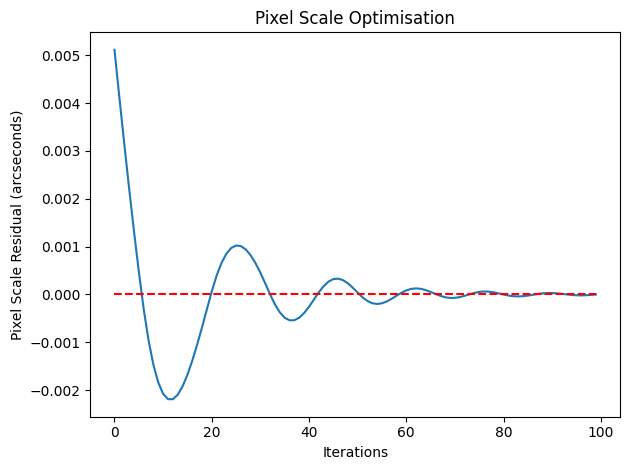

In [183]:
plt.title('Pixel Scale Optimisation')
plt.plot(pixel_scales_found-true_pixel_scale)
plt.plot(np.zeros(100),linestyle='--',color='red')
plt.xlabel('Iterations')
plt.ylabel('Pixel Scale Residual (arcseconds)')
plt.tight_layout()
plt.savefig('pixel_scale_res.pdf')
plt.show()

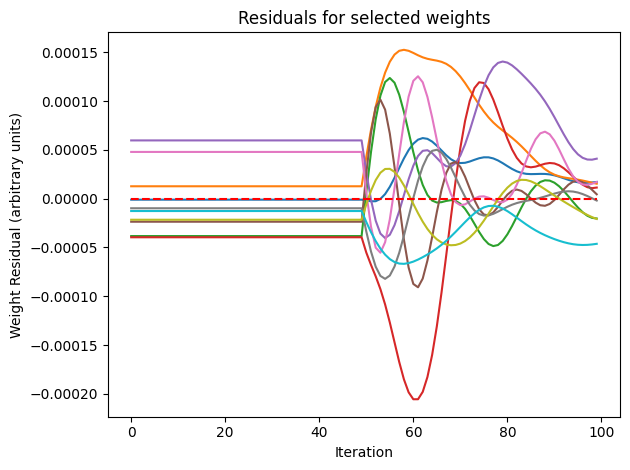

In [184]:

weights_residuals = np.array([

        models_out[it].telescope.source.spectrum.weights / np.sum(models_out[it].telescope.source.spectrum.weights)
        - weights_modified
    
    for it in np.arange(100)
])

for i in range(0, weights_residuals.shape[1], 50):  # every 10th rate index
    plt.plot(weights_residuals[:, i], label=f'Rate {i}')

plt.plot(np.zeros(100),linestyle='--',color='red')
plt.xlabel("Iteration")
plt.ylabel("Weight Residual (arbitrary units)")
plt.title("Residuals for selected weights")
plt.tight_layout()
plt.savefig('weights_res.pdf')
plt.show()

In [181]:
# basically just my learning rate for both spectra and pixel scale is a tad too high.

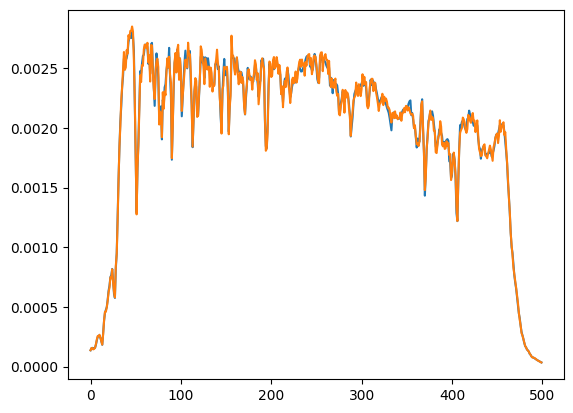

In [109]:
plt.plot(weights_norm)
plt.plot(weights_modified)
plt.show()